In [1]:
import os
import pickle
import re
import sys
from glob import glob

import climate_envs
import climlab
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"
NUM_STEPS = 200

sys.path.append(BASE_DIR)

In [3]:
def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns

In [7]:
class SCBC:
    def __init__(self):
        self.observed_temperature = (321.75 - 273.15) / 100
        self.physics_temperature = (380 - 273.15) / 100
        self.state_t0 = (300 - 273.15) / 100
        self.division_constant = (
            self.physics_temperature - self.observed_temperature
        )
        self.state = self.state_t0

    def step_forward(self):
        relaxation = (
            (self.physics_temperature - self.state)
            * 0.2
            / self.division_constant
        )
        self.state += relaxation
        return self.state


scbc = SCBC()
scbc_temps = [scbc.state]
for i in range(NUM_STEPS):
    scbc.step_forward()
    scbc_temps.append(scbc.state)
scbc_temps = np.array(scbc_temps)

In [8]:
from multiprocessing import Pool, cpu_count


def get_action_row(record_fn):
    with open(record_fn, "rb") as f:
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        scbc_state = record_steps["obs"]
        actions = record_steps["actions"]
        error = scbc_state[-1] - scbc.observed_temperature

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "obs": scbc_state,
            "actions": actions,
            "error": error,
            "fn": record_fn,
        }


def get_action_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_action_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]

In [9]:
EXPERIMENT_ID = "scbc-v0-optim-L-60k"
NUM_STEPS = 200
ALGOS = {"td3", "tqc", "ddpg"}

record_fns = get_record_fns(EXPERIMENT_ID)

df = pd.DataFrame(get_action_rows(record_fns))
df["error_mse"] = df["error"].apply(lambda x: np.mean(np.square(x)))
df.drop(columns=["error", "obs", "actions"], inplace=True)
df = df.sort_values("error_mse", ascending=True)
df.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1025.18it/s]


,exp_id,algo,seed,fn,error_mse
19,scbc-v0-optim-L-60k,td3,1,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.096593e-07
10,scbc-v0-optim-L-60k,td3,3,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,4.828476e-07
3,scbc-v0-optim-L-60k,ddpg,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,5.742791e-07
23,scbc-v0-optim-L-60k,tqc,10,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.978593e-06
0,scbc-v0-optim-L-60k,ddpg,1,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,2.898200e-05
20,scbc-v0-optim-L-60k,td3,8,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.913176e-05
17,scbc-v0-optim-L-60k,td3,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,4.131235e-05
9,scbc-v0-optim-L-60k,td3,4,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,6.084762e-05
22,scbc-v0-optim-L-60k,td3,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,7.420981e-05
15,scbc-v0-optim-L-60k,tqc,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,7.989133e-05


In [10]:
from base64 import b64encode

from IPython.display import HTML

video_path = (
    df.values[0][3]
    .replace("/records/", "/videos/")
    .replace(f"step_{NUM_STEPS}.pth", "rl-video-episode-0.mp4")
)
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    f"""
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""
)

In [11]:
from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        action_row = get_action_row(record_fn)
        algo = action_row["algo"].lower()
        seed = int(action_row["seed"])
        error = action_row["error"]
        records[algo][seed] = {
            "actions": action_row["actions"],
            "obs": action_row["obs"],
        }
    return records

In [12]:
def plot_SCBC_state_action(records, algo, exp_id):

    observed_value = scbc.observed_temperature

    param_bounds = {
        "u": (-1, 1),
    }

    def normalise(x, bounds):
        return (x - bounds[0]) / (bounds[1] - bounds[0])

    scbc_state = scbc_temps[:-2]

    obs_list = []
    u_list = []
    for s in records[algo]:
        obs = records[algo][s]["obs"]
        u = records[algo][s]["actions"]

        obs_list.append(obs)
        u_list.append(normalise(u, param_bounds["u"]))

    obs_arr = np.stack(obs_list)
    u_arr = np.stack(u_list)

    timesteps = np.arange(len(records[algo][1]["actions"]))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

    ax1.plot(
        timesteps,
        obs_arr.mean(axis=0),
        label="SCBC Model w/ RL",
        color="black",
    )
    ax1.fill_between(
        timesteps,
        obs_arr.mean(axis=0) - obs_arr.std(axis=0),
        obs_arr.mean(axis=0) + obs_arr.std(axis=0),
        color="black",
        alpha=0.2,
    )
    ax1.plot(
        timesteps,
        scbc_state,
        label="SCBC Model",
        color="black",
        linestyle="--",
    )
    ax1.axhline(observed_value, label="Observed", color="red", linestyle="--")
    ax1.set_ylabel("Temperature (°C)")
    ax1.set_title(f"{algo.upper()}")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(
        timesteps,
        u_arr.mean(axis=0),
        label="Heating Increment",
        color="tab:blue",
    )
    ax2.fill_between(
        timesteps,
        u_arr.mean(axis=0) - u_arr.std(axis=0),
        u_arr.mean(axis=0) + u_arr.std(axis=0),
        color="tab:blue",
        alpha=0.3,
    )

    ax2.set_ylabel("Normalised [0–1]")
    ax2.set_xlabel("Timestep")
    ax2.set_ylim(-0.25, 1.25)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{IMGS_DIR}/{exp_id}_{algo}_TU.png", dpi=300)

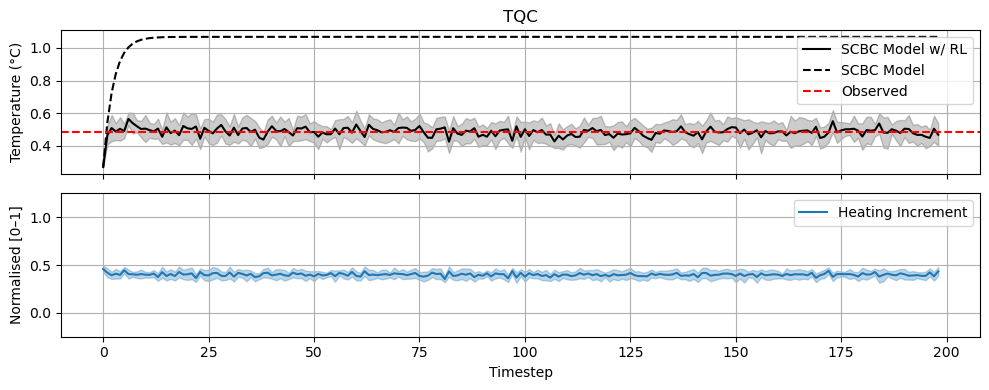

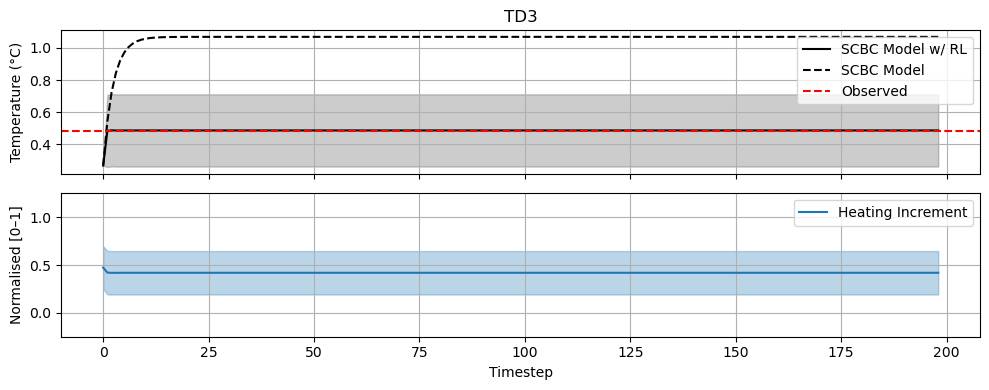

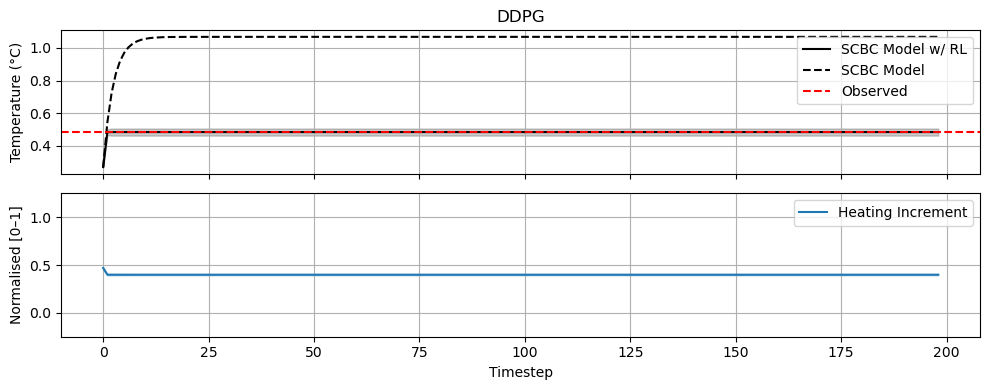

In [13]:
records = get_records(record_fns)

for algo in ALGOS:
    plot_SCBC_state_action(records, algo, EXPERIMENT_ID)